## Name: {Claire Zhou}
## Section: {02}

# Lab 6: Partitioning Feature Space

## Tools

#### Libraries:

- numpy: for processing
- sklearn: for model training  
- pandas: for data processing  
- dtreeviz: for visualization

#### Datasets:

I'll suggest a couple of datasets here, but feel free to import some of your own and experiment. **sklearn.datasets** is a good place to start.

- Wine data
- cars data provided as a csv

## Setup

**Make sure to get latest dtreeviz**

`dtreeviz` is a library that was created by a previous USF professor and MSDS student specifically for visualizing decision tree output.

In [1]:
! pip install -U -q dtreeviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_wine
from sklearn.metrics import mean_squared_error, accuracy_score


from sklearn import tree
import dtreeviz
from dtreeviz import decision_boundaries
from dtreeviz.models.shadow_decision_tree import ShadowDecTree

In [2]:
# this function will output some information about the leaf nodes of a decision tree
def show_mse_leaves(X,y,max_depth):
    t = DecisionTreeRegressor(max_depth=max_depth)
    t.fit(X,y)
    shadow = ShadowDecTree.get_shadow_tree(t, X, y, feature_names=['sqfeet'], target_name='rent')
    root, leaves, internal = shadow._get_tree_nodes()
    n_node_samples = t.tree_.n_node_samples

    mse = 99.9
    print(f"Root {0:3d} has {n_node_samples[0]:3d} observations with MSE ={mse:6.2f}")
    print("-----------------------------------------")

    avg_mse_per_record = 0.0
    node2samples = shadow.get_node_samples()
    for node in leaves:
        leafy = y[node2samples[node.id]]
        n = len(leafy)
        mse = mean_squared_error(leafy, [np.mean(leafy)]*n)
        avg_mse_per_record += mse * n
        print(f"Node {node.id:3d} has {n_node_samples[node.id]:3d} observations with MSE ={mse:6.2f}")

    avg_mse_per_record /= len(y)
    print(f"Average MSE per record is {avg_mse_per_record:.1f}")

## Regression

First we'll load the cars data and fit a decision tree on it to predict MPG from ENG only. We'll also make a scatterplot of the data using the dtreeviz library.

In [5]:
df_cars = pd.read_csv("cars.csv")
X, y = df_cars[['ENG']], df_cars['MPG']
df_cars.head(3)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


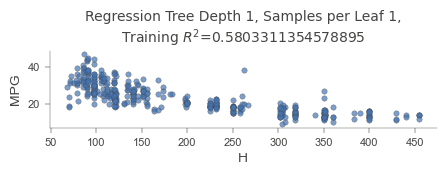

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names='Horsepower',
                           target_name='MPG')

viz_model.rtree_feature_space(show={'title'}, features=['Horsepower'],
                             figsize=(5,1))

---

**Q.** What is the MSE between y and predicted $\hat{y} = \overline{y}$?

Hint: You can use function `mean_squared_error(` $y$,$\hat{y}$ `)`; create a vector of length $|y|$ with $\bar{y}$ as elements.

In [7]:
mean_squared_error(y, [np.mean(y)]*len(y))

60.76273740016168

<details>
<summary>Solution</summary>
<pre>
mean_squared_error(y, [np.mean(y)]*len(y)) # about 60.76
</pre>
</details>

---

**Q.** Where would you split this if you could only split once?  Set the `split` variable to a reasonable value.

In [8]:
split = 200

<details>
<summary>Solution</summary>
The split location that gets most pure subregion might be about split = 200 HP because the region to the right has a relatively flat MPG average.
</details>

**Alter the rtreeviz_univar() call to show the split with arg show={'splits'}**

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


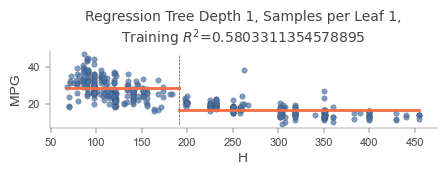

In [9]:
viz_model.rtree_feature_space(show={'splits','title'}, features=['Horsepower'],
                             figsize=(5,1))

---

**Q.** What are the MSE values for the left, right partitions?

Hint: Get the y values whose `X['ENG']` are less than `split` into `lefty` and those greater than or equal to `split` into `righty`.  The split introduces two new children that are leaves until we (possibly) split them; the leaves predict the mean of their samples.

In [10]:
lefty = y[X['ENG'] < split]
righty = y[X['ENG'] >= split]
mleft = np.mean(lefty)
mright = np.mean(righty)

mse_left = mean_squared_error(lefty, [mleft]*len(lefty))
mse_right = mean_squared_error(righty, [mright]*len(righty))

mse_left, mse_right

(35.68916307096633, 12.770261374699789)

<details>
<summary>Solution</summary>
    Should be (35.68916307096633, 12.770261374699789)<p>
<pre>
lefty = y[X['ENG'] < split]
righty = y[X['ENG'] >= split]
mleft = np.mean(lefty)
mright = np.mean(righty)

mse_left = mean_squared_error(lefty, [mleft]\*len(lefty))
mse_right = mean_squared_error(righty, [mright]\*len(righty))
</pre>
</details>

---

**Q.** Compare the MSE values for overall y and the average of the left, right partition MSEs (which is about 24.2)?

In [11]:
(mse_left + mse_right)/2

24.229712222833058

### The MSE for overall y is a lot higher than the average

---

**Q.** Set the split value to 100 and recompare MSE values for y, left, and right.

In [12]:
split = 100
lefty = y[X['ENG'] < split]
righty = y[X['ENG'] >= split]
mleft = np.mean(lefty)
mright = np.mean(righty)

mse_left = mean_squared_error(lefty, [mleft]*len(lefty))
mse_right = mean_squared_error(righty, [mright]*len(righty))

mse_left, mse_right
(mse_left+mse_right)/2

37.30550515645581

### the MSE for y is double the average mse after the split at 100.

### Effect of deeper trees

Consider the sequence of tree depths 1 through 6 for horsepower vs MPG. Let's take a look at the split points for each of the trees with a different depth.

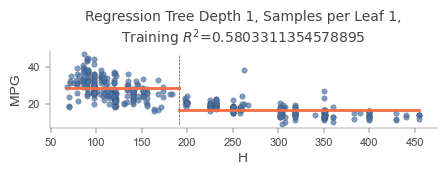

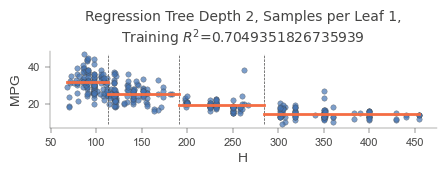

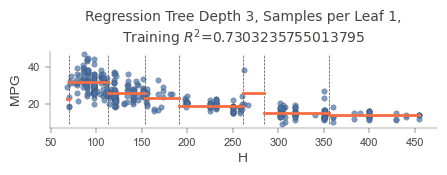

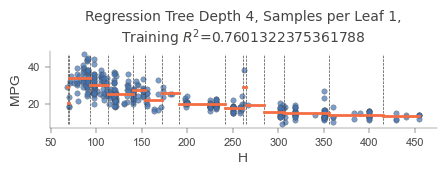

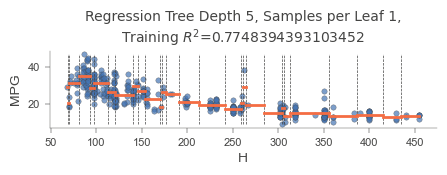

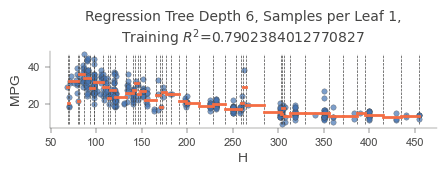

In [13]:
X = df_cars[['ENG']].values
y = df_cars['MPG'].values

for i in range(6):
    dt = DecisionTreeRegressor(max_depth=i+1)
    dt.fit(X, y)
    viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names='Horsepower',
                           target_name='MPG')

    t = viz_model.rtree_feature_space(show={'title', 'splits'}, features=['Horsepower'],
                             figsize=(5,1))

---

**Q.** Focusing on the orange horizontal lines, what do you notice as more splits appear?

### as more splits appear, the fit of the model does not improve much. THe best is at Depth 2.

---

**Q.** Consider the MSE for the 4 leaves of a depth 2 tree and 15 leaves of a depth 4 tree.  What happens to the average MSE per leaf?  What happens to the leaf sizes and how is it related to average MSE?

In [14]:
show_mse_leaves(df_cars[['ENG']], df_cars['MPG'], max_depth=2)

Root   0 has 392 observations with MSE = 99.90
-----------------------------------------
Node   2 has 120 observations with MSE = 30.45
Node   3 has 102 observations with MSE = 20.07
Node   5 has  72 observations with MSE =  9.23
Node   6 has  98 observations with MSE =  6.76
Average MSE per record is 17.9


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


In [15]:
show_mse_leaves(df_cars[['ENG']], df_cars['MPG'], max_depth=4)

Root   0 has 392 observations with MSE = 99.90
-----------------------------------------
Node   4 has   1 observations with MSE =  0.00
Node   5 has   3 observations with MSE =  6.18
Node   7 has  51 observations with MSE = 29.27
Node   8 has  65 observations with MSE = 20.59
Node  11 has  68 observations with MSE = 20.26
Node  12 has  16 observations with MSE =  9.32
Node  14 has  13 observations with MSE = 23.93
Node  15 has   5 observations with MSE =  3.21
Node  19 has  44 observations with MSE =  2.91
Node  20 has  25 observations with MSE =  4.35
Node  22 has   2 observations with MSE = 81.00
Node  23 has   1 observations with MSE =  0.00
Node  26 has  22 observations with MSE =  6.03
Node  27 has  47 observations with MSE =  8.26
Node  29 has  20 observations with MSE =  3.81
Node  30 has   9 observations with MSE =  1.51
Average MSE per record is 14.6


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


### The average MSE per leaf decreases as the number of leaves increases but not by much.

---

Consider the plot of the MPG versus the CYL feature (num cylinders):

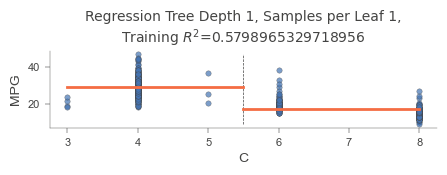

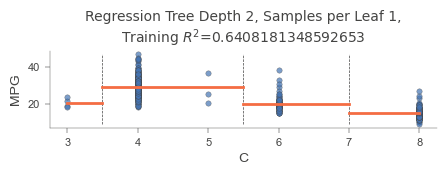

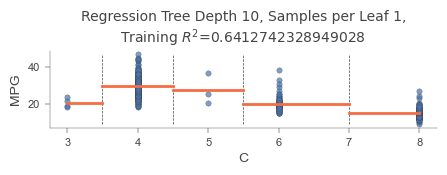

In [16]:
X = df_cars[['CYL']].values
y = df_cars['MPG'].values

depths = [1,2,10]

for i in depths:
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(X, y)
    viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names='Cylinders',
                           target_name='MPG')

    t = viz_model.rtree_feature_space(show={'title', 'splits'}, features=['Cylinders'],
                             figsize=(5,1))

---

**Q.** Explain why the graph looks like a bunch of vertical bars.

### These are categorical variables.

---

**Q.** Why don't we get many more splits for depth 10 vs depth 2?

### with the limited number of categories available, there is no way to further split the data points.

---

**Q.** Why are the orange predictions bars at the levels they are in the plot?

### The orange bars represent the mean MPG for each category of C.

## Classification

Now let's do classification using the wine data.

In [17]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [18]:
feature_names = list(wine.feature_names)
class_names = list(wine.target_names)

### One Feature

Let's take a look at a plot of the wine data.

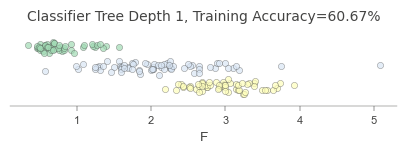

In [19]:
X = df_wine[['flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names='Flavanoids',
                           target_name='Wine')

viz_model.ctree_feature_space(show={'title'}, features=['Flavanoids'],
                             figsize=(5,1))


---

**Q.** Where would you split this (vertically) if you could only split once?

### Split at 2.

---

**Alter the code to show the split with arg show={'splits'}**

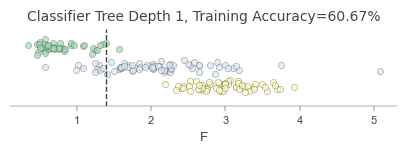

In [21]:
viz_model.ctree_feature_space(show={'title', 'splits'}, features=['Flavanoids'],
                             figsize=(5,1))

---

**Q.** For max_depth=2, how many splits will we get?

### 3

---

**Q.** Where would you split this graph in that many places?

### 1 and 2.2

---

**Alter the code to show max_depth=2**

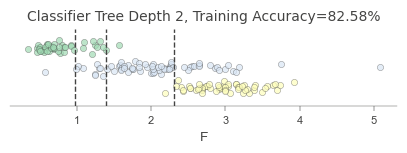

In [22]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names='Flavanoids',
                           target_name='Wine')

viz_model.ctree_feature_space(show={'title', 'splits'}, features=['Flavanoids'],
                             figsize=(5,1))

### Gini impurity

Let's compute the gini impurity for left and right sides for a depth=1 tree that splits flavanoids at 1.3. Here's a function that computes the value:

$$
Gini({\bf p}) = \sum_{i=1}^{k} p_i \left[ \sum_{j \ne i}^k p_j \right] = \sum_{i=1}^{k} p_i (1 - p_i) = 1 - \sum_{i=1}^{k} p_i^2
$$

where $p_i = \frac{|y[y==i]|}{|y|}$. Since $\sum_{j \ne i}^k p_j$ is the probability of "not $p_i$", we can summarize that as just $1-p_i$. The gini value is then computing $p_i$ times "not $p_i$" for $k$ classes.  Value $p_i$ is the probability of seeing class $i$ in a list of target values, $y$. 

In [23]:
def gini(y):
    """
    Compute gini impurity from y vector of class values (from k unique values).
    Result is in range 0..(k-1/k) inclusive; binary range is 0..1/2.
    See https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity"
    """
    _, counts = np.unique(y, return_counts=True)
    p = counts / len(y)
    return 1 - np.sum( p**2 )

---

**Q.** Using that function, what is the gini impurity for the overall y target

In [24]:
gini(y)

0.6583133442747129

<details>
<summary>Solution</summary>
gini(y) # about 0.66
</details>


---

**Get all y values for rows where `df_wine['flavanoids']`<1.3 into variable `lefty` and `>=` into `righty`**

In [25]:
lefty = y[df_wine['flavanoids']<1.3]
righty = y[df_wine['flavanoids']>=1.3]

---

**Q.** What are the gini values for left and right partitions?

In [26]:
gini(lefty), gini(righty) 

(0.2368319876970395, 0.529233058466117)

<details>
<summary>Solution</summary>
gini(lefty), gini(righty) # about 0.24, 0.53
</details>

---

**Q.** What can we conclude about the purity of left and right? Also, compare to gini  for all y values.

### The left partiion has a lower impurity level which is aligned with what we see from the graph. Both left and right improves impurity levels in comparison to the root node.

### Two Features

Let's do something similar, but for two features instead of one.

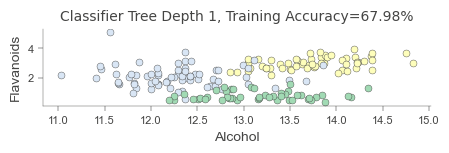

In [27]:
X = df_wine[['alcohol','flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names=['Alcohol', 'Flavanoids'],
                           target_name='Wine')

viz_model.ctree_feature_space(show={'title'}, features=['Alcohol', 'Flavanoids'],
                             figsize=(5,1))

---

**Q.** Which variable and split point would you choose if you could only split once?

### 12.8

---
**Modify the code to view the splits and compare your answer**

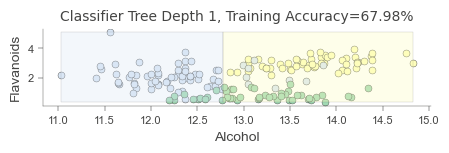

In [28]:
viz_model.ctree_feature_space(show={'title', 'splits'}, features=['Alcohol', 'Flavanoids'],
                             figsize=(5,1))

---

**Q.** Which variable and split points would you choose next for depth=2?

### Flavanoids at 0.7 and 1.5.

---
**Modify the code to view the splits for depth=2 and compare your answer**

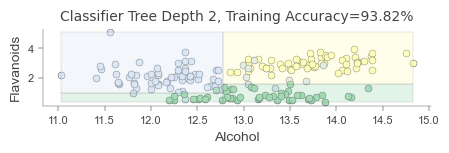

In [29]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names=['Alcohol', 'Flavanoids'],
                           target_name='Wine')

viz_model.ctree_feature_space(show={'title', 'splits'}, features=['Alcohol', 'Flavanoids'],
                             figsize=(5,1))

### Gini

Let's now examine the gini impurity index for a different pair of variables.

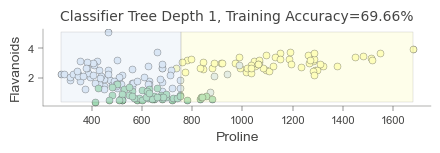

In [30]:
X = df_wine[['proline','flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=y,
                           feature_names=['Proline', 'Flavanoids'],
                           target_name='Wine')

viz_model.ctree_feature_space(show={'title', 'splits'}, features=['Proline', 'Flavanoids'],
                             figsize=(5,1))

---

**Get all y values for rows where the split var is less than the split value into variable `lefty` and those `>=` into `righty`**

In [31]:
lefty = y[df_wine['proline']<750]
righty = y[df_wine['proline']>=750]

---

**Print out the gini for y, lefty, righty**

In [32]:
gini(y), gini(lefty), gini(righty)

(0.6583133442747129, 0.4908725652895449, 0.33564768895060504)